In [1]:
# 載入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

乘客的ID(PassengerId)、乘客存活與否(Survived)、乘客艙等(pClass)、乘客姓名(Name)、性別(Sex)、年齡(Age)、兄弟姊妹＋老婆丈夫數量(SibSp)、父母小孩的數量(Parch)、票號(Ticket)、票的費用(Fare)、出發港口(Embarked)等。

運用這些資料去預估乘客是否會在鐵達尼號意外中生存下來。
- 1 表示 True（存活）。
- 0 表示 False（未存活或死亡）。

In [2]:
# 使用資料夾內鐵達尼號的資料集，練習邏輯迴歸的處理邏輯
train = pd.read_csv('data/titanic_data.csv')
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C


# 探索資料

In [3]:
# 探索資料
print("Data shape:", train.shape)

print("Data description:")
train.describe()

Data shape: (891, 11)
Data description:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


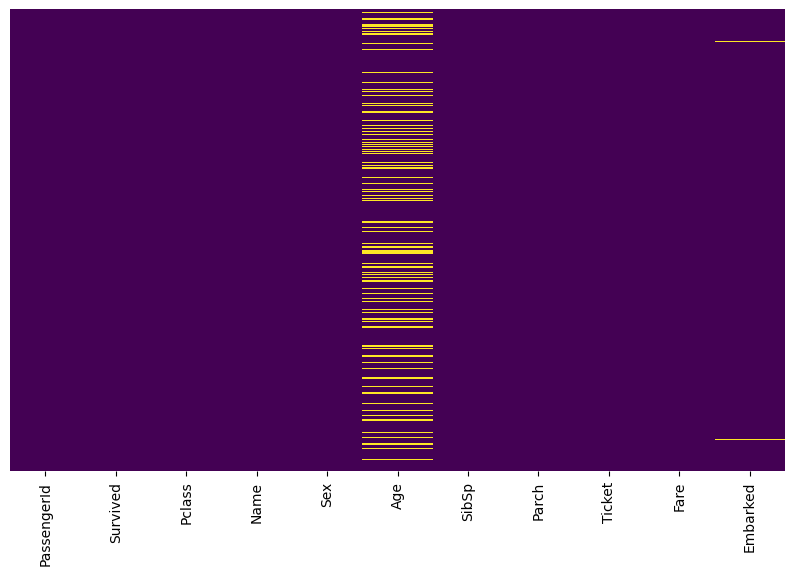

In [4]:
# 用heatmap(.isnull()來找出缺失的資料在哪些欄位。Age似乎約有五分之一的資料缺失，可用合理資料補充。)
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

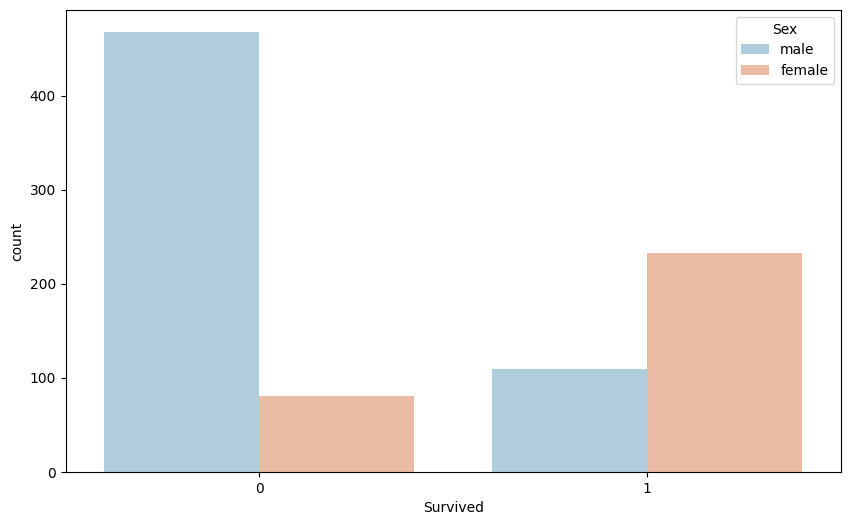

In [5]:
# 用countplot來看性別是否影響最後存活。女性存活比例比男性高。
plt.figure(figsize=(10, 6))
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')
plt.show()

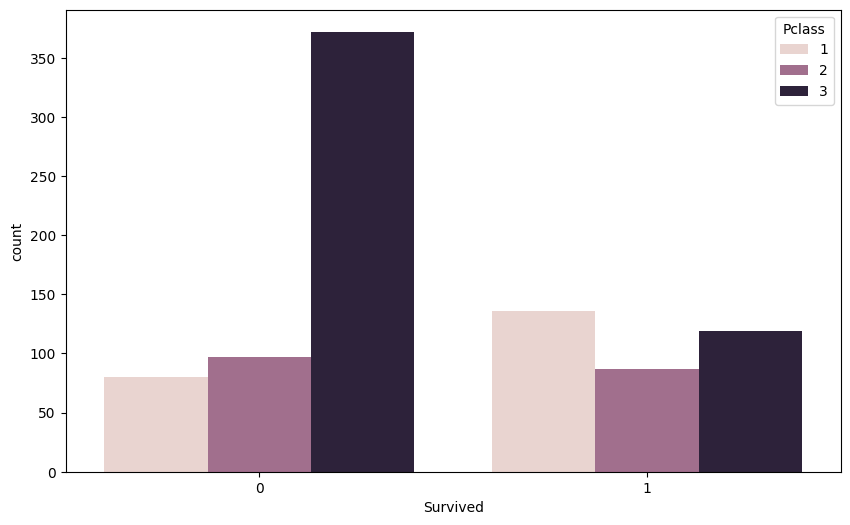

In [6]:
# 艙等是否也影響存活?
plt.figure(figsize=(10, 6))
sns.countplot(x='Survived',hue='Pclass',data=train)
plt.show()

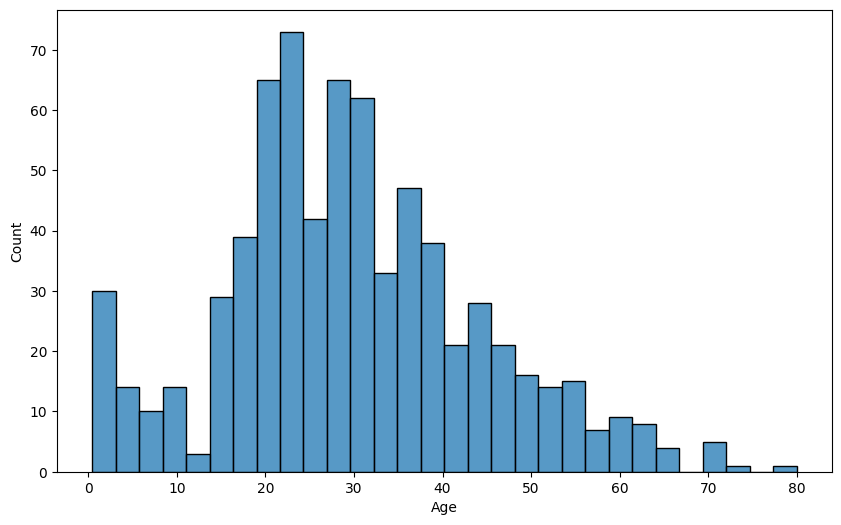

In [7]:
# 用直方圖看年齡分佈。缺失資料在此不計。
plt.figure(figsize=(10, 6))
sns.histplot(train['Age'].dropna(),kde=False,bins=30)
plt.show()

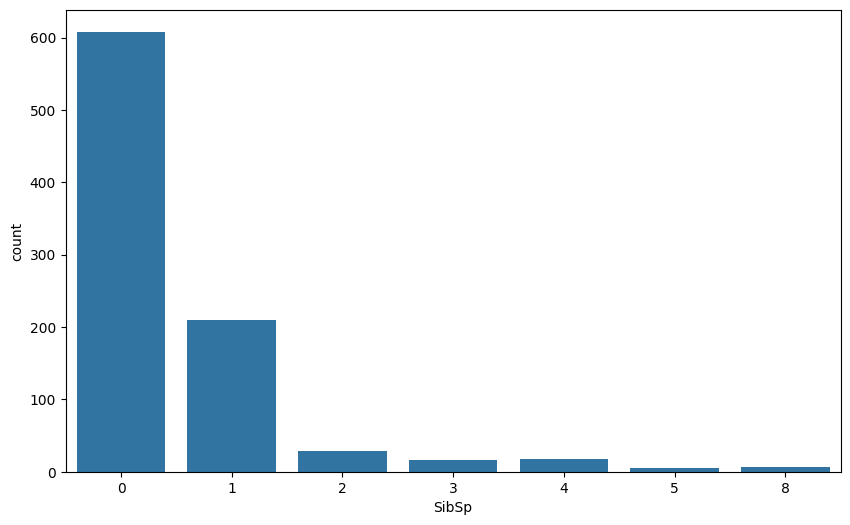

In [8]:
# SibSp代表兄弟姐妹或眷屬人數
plt.figure(figsize=(10, 6))
sns.countplot(x='SibSp',data=train)

# # 單一顏色
# sns.countplot(x='SibSp', data=train, color='skyblue')
# # 使用調色板
# sns.countplot(x='SibSp', hue='SibSp', data=train, palette='rainbow', dodge=False)
# # 隱藏圖例
# plt.legend([],[], frameon=False)

plt.show()

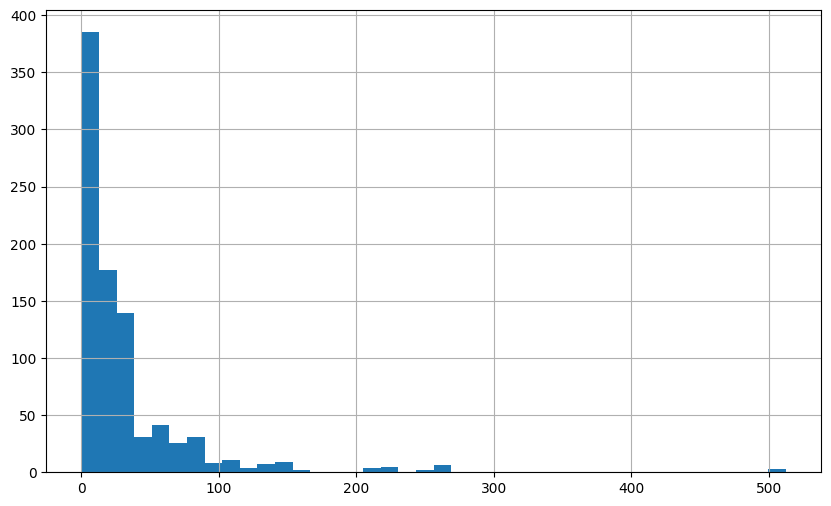

In [9]:
# 用直方圖看票價分佈
plt.figure(figsize=(10, 6))
train['Fare'].hist(bins=40)
plt.show()

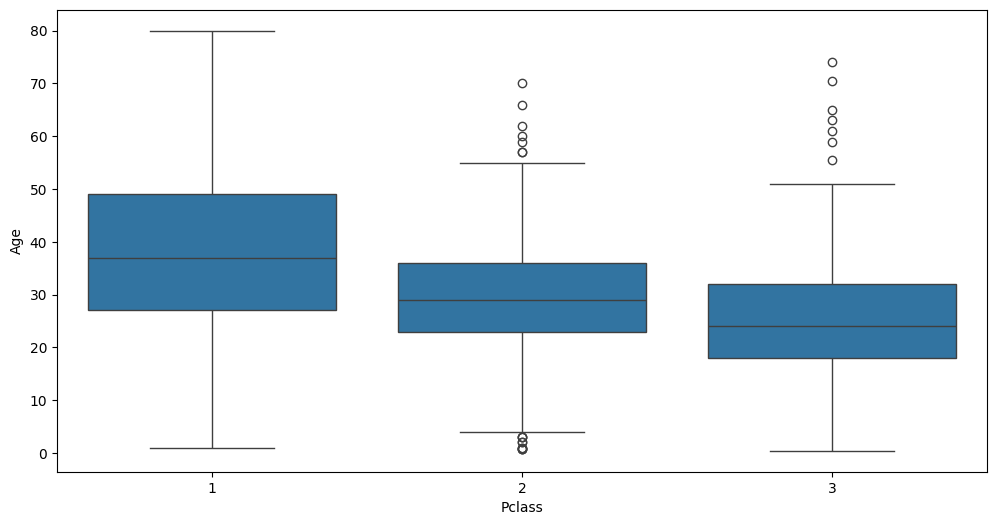

In [10]:
# 使用盒鬚圖來看年齡和艙等的分佈。看起來頭等艙年齡較高，隨之降低。
plt.figure(figsize=(12,6))
sns.boxplot(x='Pclass',y='Age',data=train)
plt.show()

# 資料清理

## 缺失值

剛有看到年齡資料約有五分之一缺失，一種做法是棄之不用，一種可以考慮把年齡平均放進去。

把艙等平均年齡填入缺失的資料中
- 艙等1平均年齡是37，艙等2平均年齡是29，艙等3平均年齡是24

In [11]:
# 定義填補年齡缺失值的函數
def impute_age(cols):
    Age = cols.iloc[0]
    Pclass = cols.iloc[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

# 填補年齡缺失值
train['Age'] = train[['Age','Pclass']].apply(impute_age, axis=1)

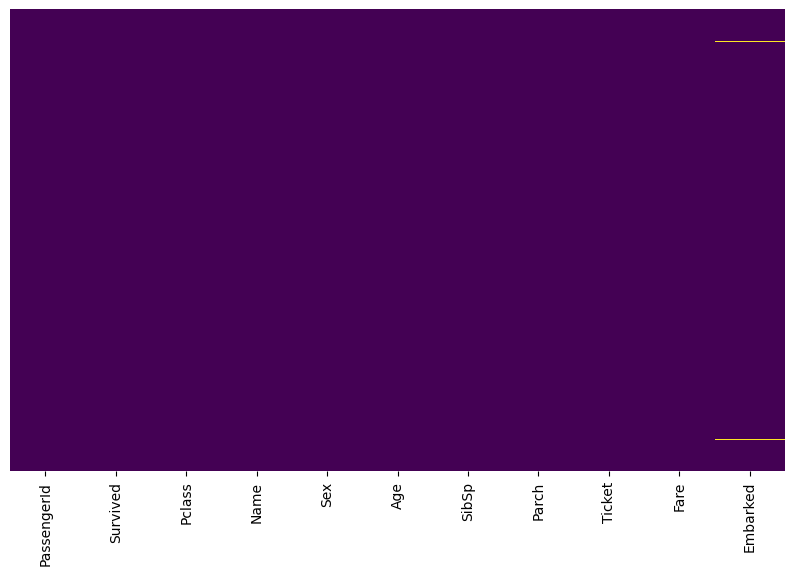

In [12]:
# 用heatmap查看年齡是否還有缺失資料
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

有缺失值直接刪除

In [13]:
# inplace False返回新的數據集(默認)、True在原數據集上操作
# train.dropna(inplace=True)

In [14]:
# 填補登船港口的缺失值，可以用最常見的值來填補
most_common_embarked = train['Embarked'].mode()[0]
train['Embarked'] = train['Embarked'].fillna(most_common_embarked)

In [15]:
# 檢查是否還有缺失值
print(train.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


## 類別資料轉為數值變數

In [16]:
# 虛擬變數範例
# 使用pandas(d.get_dummies)將性別從類別資料轉為數值變數。
sex = pd.get_dummies(train['Sex'],drop_first=True)

# 請將drop_first=True，如果為True會刪除第一個類別值。
# 本來若有k個level，drop_first=True會只剩下k-1個level，降低共線性的可能
sex.head()

,male
0,True
1,False
2,False
3,False
4,True


In [17]:
# 使用pandas將上船的港口從類別資料改換為數值變數(drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)
embark.head()

,Q,S
0,False,True
1,False,False
2,False,True
3,False,True
4,False,True


In [18]:
# 將性別及上船港口的數值變數和原始的data結合
train = pd.concat([train,sex,embark],axis=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,True,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,False,False,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,True,False,True


In [19]:
# 將原始的性別、登船港口、票號、姓名欄位棄用
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,True,False,True
1,2,1,1,38.0,1,0,71.2833,False,False,False
2,3,1,3,26.0,0,0,7.9250,False,False,True
3,4,1,1,35.0,1,0,53.1000,False,False,True
4,5,0,3,35.0,0,0,8.0500,True,False,True


In [20]:
# 因為PassengerId在此也只是排序，因此也棄用
train.drop('PassengerId',axis=1,inplace=True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


# 準備特徵和標籤

In [21]:
# 建立feature資料集(選取survived以外所有欄位)與target資料集(survived)
X = train.drop('Survived',axis=1)
y = train['Survived']

In [22]:
# 分割數據集為訓練集和測試集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

In [23]:
# 載入邏輯回歸
from sklearn.linear_model import LogisticRegression

# 初始化邏輯迴歸模型
logmodel = LogisticRegression(max_iter=1000)
# 訓練模型
logmodel.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [24]:
# 使用模型進行訓練集資料的預測
pred_train = logmodel.predict(X_train)

# 使用模型進行測試集資料的預測
pred_test = logmodel.predict(X_test)

In [25]:
# ground truth
print(f'y_train: {y_train.values}')
print(f'y_test: {y_test.values}')

y_train: [1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1
 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0
 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0
 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0
 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1
 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1
 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0
 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0
 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0
 1 1 0 1 1 1 0 1

In [26]:
# ground truth
print(y_test.values)
print(y_train.values)

[0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0
 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1
 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1
 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 1 0
 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1
 0 0 1 1 0 1 1 0 1]
[1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1
 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0
 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0
 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0
 0 1 

# 計算accuracy及結果顯示

accuracy<br>
error_index #錯誤答案是哪幾筆資料<br>
miss classification #錯誤答案<br>
錯誤欄位的正確之原始資料表格

In [27]:
# 計算準確率
error_index_train = np.where(pred_train != y_train.values)[0]
train_accuracy = 1 - len(error_index_train) / len(X_train)
print('train accuracy:', train_accuracy)

error_index_test = np.where(pred_test != y_test.values)[0]
test_accuracy = 1 - len(error_index_test) / len(X_test)
print('test accuracy:', test_accuracy)

train accuracy: 0.8186195826645265
test accuracy: 0.7835820895522388


In [28]:
# 錯誤答案位置
print('error_index:', error_index_test)
# 錯誤答案
print('miss classification:', pred_test[error_index_test])

# 錯誤分類的原始數據
data_index = y_test.iloc[error_index_test].index
print(train.iloc[data_index])  # 錯誤欄位的正確之原始資料

error_index: [  2   3   6  13  14  33  39  45  55  56  63  67  70  71  74  82  86  89
  94  99 103 104 109 110 111 114 125 127 129 147 151 155 157 162 164 180
 181 184 192 195 197 198 200 201 205 206 208 210 220 221 230 231 235 240
 249 250 262 265]
miss classification: [1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0
 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0]
     Survived  Pclass   Age  SibSp  Parch      Fare   male      Q      S
748         0       1  19.0      1      0   53.1000   True  False   True
751         1       3   6.0      0      1   12.4750   True  False   True
740         1       1  37.0      0      0   30.0000   True  False   True
127         1       3  24.0      0      0    7.1417   True  False   True
630         1       1  80.0      0      0   30.0000   True  False   True
74          1       3  32.0      0      0   56.4958   True  False   True
724         1       1  27.0      1      0   53.1000   True  False   True
298         1       1  37.